In [103]:
import MetaTrader5 as mt5
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf

from typing import List, Optional

In [104]:
mt5.initialize()

True

In [105]:
def get_highest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 2) -> pd.Series:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)

    merged_df = pd.concat([left_bars, right_bars])
    highest_bar = merged_df.nlargest(1, 'high')
    highest_bar = highest_bar.iloc[-1]

    return pivot_bar if highest_bar['high'] < pivot_bar['high'] else highest_bar

def get_lowest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 2) -> pd.Series:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)
    
    merged_df = pd.concat([left_bars, right_bars])
    lowest_bar = merged_df.nsmallest(1, 'low')
    lowest_bar = lowest_bar.iloc[-1]

    return pivot_bar if lowest_bar['low'] > pivot_bar['low'] else lowest_bar

def is_bearish_divergence(df: pd.DataFrame, current_candle: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_high = df[(df['rsi_pivot_high']) & (df['time'] < current_candle['time']) & (df['rsi'] > current_candle['rsi'])]
        
    if not nearest_rsi_pivot_high.empty:
        nearest_rsi_pivot_high = nearest_rsi_pivot_high.iloc[-1]
        
        if nearest_rsi_pivot_high['rsi'] > 70:
            current_candle = get_highest_pivot_bar(df, current_candle)
            nearest_pivot_high_candle = get_highest_pivot_bar(df, nearest_rsi_pivot_high)
            
            if current_candle['high'] > nearest_pivot_high_candle['high']:
                return nearest_rsi_pivot_high
    
    return None

def is_bullish_divergence(df: pd.DataFrame, current_candle: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_low = df[(df['rsi_pivot_low']) & (df['time'] < current_candle['time']) & (df['rsi'] < current_candle['rsi'])]
    if not nearest_rsi_pivot_low.empty:
        nearest_rsi_pivot_low = nearest_rsi_pivot_low.iloc[-1]

        if nearest_rsi_pivot_low['rsi'] < 40:
            current_candle = get_lowest_pivot_bar(df, current_candle)
            nearest_pivot_low_candle = get_lowest_pivot_bar(df, nearest_rsi_pivot_low)

            if current_candle['low'] < nearest_pivot_low_candle['low']:
                return nearest_rsi_pivot_low
            
    return None
    
def detect_divergence(df: pd.DataFrame):
    price_lines = []
    rsi_lines = []

    for _, current_candle in df.iterrows():
        if current_candle['rsi_pivot_low']:
            bullish_divergence_point = is_bullish_divergence(df, current_candle)
            if bullish_divergence_point is not None:
                rsi_lines.append([
                    (bullish_divergence_point['time'], bullish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])
                
                current_candle = get_lowest_pivot_bar(df, current_candle)
                nearest_pivot_low_candle = get_lowest_pivot_bar(df, bullish_divergence_point)
                price_lines.append([
                    (nearest_pivot_low_candle['time'], nearest_pivot_low_candle['low']),
                    (current_candle['time'], current_candle['low'])
                ])

        if current_candle['rsi_pivot_high']:
            bearish_divergence_point = is_bearish_divergence(df, current_candle)
            if bearish_divergence_point is not None:
                rsi_lines.append([
                    (bearish_divergence_point['time'], bearish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])

                current_candle = get_highest_pivot_bar(df, current_candle)
                nearest_pivot_high_candle = get_highest_pivot_bar(df, bearish_divergence_point)
                price_lines.append([
                    (nearest_pivot_high_candle['time'], nearest_pivot_high_candle['high']),
                    (current_candle['time'], current_candle['high'])
                ])

    return price_lines, rsi_lines

In [106]:
from numpy import NaN, select
from pandas import DataFrame, to_datetime, infer_freq
from pandas_ta.utils import is_datetime_ordered, verify_series


def pivot_points(_open, high, low, close, anchor=None, method=None):
    _open = verify_series(_open)
    high = verify_series(high)
    low = verify_series(low)
    close = verify_series(close)
    anchor = anchor.upper() if anchor and isinstance(anchor, str) and len(anchor) >= 1 else "D"
    method_list = ["traditional", "fibonacci", "woodie", "classic", "demark", "camarilla"]
    method = method if method in method_list else "traditional"
    date = (
        to_datetime(close.index, unit="ms")
        if not is_datetime_ordered(close) and verify_series(close)
        else close.index
    )

    freq = infer_freq(date)
    df = DataFrame(
        index=date,
        data={"open": _open.values, "high": high.values, "low": low.values, "close": close.values},
    )

    if freq is not anchor:
        a = DataFrame()
        a["open"] = df["open"].resample(anchor).first()
        a["high"] = df["high"].resample(anchor).max()
        a["low"] = df["low"].resample(anchor).min()
        a["close"] = df["close"].resample(anchor).last()
    else:
        a = df

    # Calculate the Pivot Points
    if method == "traditional":
        a["p"] = (a.high.values + a.low.values + a.close.values) / 3

        a["bc"] = (a.high.values + a.low.values ) / 2
        a["tc"] = (2 * a.p.values) - a.bc.values
        a["rng"] = abs(a.tc.values-a.bc.values)/a.p.values*100

        a["s1"] = (2 * a.p.values) - a.high.values
        a["s2"] = a.p.values - (a.high.values - a.low.values)
        a["s3"] = a.p.values - (a.high.values - a.low.values) * 2
        a["r1"] = (2 * a.p.values) - a.low.values
        a["r2"] = a.p.values + (a.high.values - a.low.values)
        a["r3"] = a.p.values + (a.high.values - a.low.values) * 2
    elif method == "fibonacci":
        a["p"] = (a.high.values + a.low.values + a.close.values) / 3
        a["pivot_range"] = a.high.values - a.low.values
        a["s1"] = a.p.values - 0.382 * a.pivot_range.values
        a["s2"] = a.p.values - 0.618 * a.pivot_range.values
        a["s3"] = a.p.values - 1 * a.pivot_range.values
        a["r1"] = a.p.values + 0.382 * a.pivot_range.values
        a["r2"] = a.p.values + 0.618 * a.pivot_range.values
        a["r3"] = a.p.values + 1 * a.pivot_range.values
        a.drop(["pivot_range"], axis=1, inplace=True)
    elif method == "woodie":
        a["pivot_range"] = a.high.values - a.low.values
        a["p"] = (a.high.values + a.low.values + a.open.values * 2) / 4
        a["s1"] = a.p.values * 2 - a.high.values
        a["s2"] = a.p.values - 1 * a.pivot_range.values
        a["s3"] = a.high.values + 2 * (a.p.values - a.low.values)
        a["s4"] = a.s3 - a.p.values
        a["r1"] = a.p.values * 2 - a.low.values
        a["r2"] = a.p.values + 1 * a.pivot_range.values
        a["r3"] = a.low.values - 2 * (a.high.values - a.p.values)
        a["r4"] = a.r3 + a.p.values
        a.drop(["pivot_range"], axis=1, inplace=True)
    elif method == "classic":
        a["p"] = (a.high.values + a.low.values + a.close.values) / 3
        a["pivot_range"] = a.high.values - a.low.values
        a["s1"] = a.p.values * 2 - a.high.values
        a["s2"] = a.p.values - 1 * a.pivot_range.values
        a["s3"] = a.p.values - 2 * a.pivot_range.values
        a["s4"] = a.p.values - 3 * a.pivot_range.values
        a["r1"] = a.p.values * 2 - a.low.values
        a["r2"] = a.p.values + 1 * a.pivot_range.values
        a["r3"] = a.p.values + 2 * a.pivot_range.values
        a["r4"] = a.p.values + 3 * a.pivot_range.values
        a.drop(["pivot_range"], axis=1, inplace=True)
    elif method == "demark":
        conds = (
            a.close.values == a.open.values,
            a.close.values > a.open.values,
        )
        vals = (
            a.high.values + a.low.values + a.close.values * 2,
            a.high.values * 2 + a.low.values + a.close.values,
        )
        p = select(conds, vals, default=(a.high.values + a.low.values * 2 + a.close.values))
        a["p"] = p / 4
        a["s1"] = p / 2 - a.high.values
        a["r1"] = p / 2 - a.low.values
    elif method == "camarilla":
        a["p"] = (a.high.values + a.low.values + a.close.values) / 3
        a["pivot_range"] = a.high.values - a.low.values
        a["s1"] = a.close.values - a.pivot_range.values * 1.1 / 12
        a["s2"] = a.close.values - a.pivot_range.values * 1.1 / 6
        a["s3"] = a.close.values - a.pivot_range.values * 1.1 / 4
        a["s4"] = a.close.values - a.pivot_range.values * 1.1 / 2
        a["r1"] = a.close.values + a.pivot_range.values * 1.1 / 12
        a["r2"] = a.close.values + a.pivot_range.values * 1.1 / 6
        a["r3"] = a.close.values + a.pivot_range.values * 1.1 / 4
        a["r4"] = a.close.values + a.pivot_range.values * 1.1 / 2
        a.drop(["pivot_range"], axis=1, inplace=True)
    else:
        raise ValueError("Invalid method")

    if freq is not anchor:
        pivots_df = a.reindex(df.index, method="ffill")
    else:
        pivots_df = a

    pivots_df.drop(columns=["open", "high", "low", "close"], inplace=True)

    x = pivots_df.loc[lambda x: (x.index.hour == 23) & (x.index.minute == 59)]
    if not x.empty:
        x = x.iloc[0].name
        pivots_df.loc[:x] = NaN

    return pivots_df

In [107]:
rates = mt5.copy_rates_from_pos('ETHUSD', mt5.TIMEFRAME_M5, 0, 1000)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(rates['time'], unit='s')
df['rsi'] = ta.rsi(df['close'], 14)

df.dropna(inplace=True)
df.set_index(df['time'], inplace=True)

window_size = 3
df['rsi_pivot_high'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).max()
df['rsi_pivot_low'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).min()

points = pivot_points(df['open'], df['high'], df['low'], df['close'], method='fibonacci')

last_timestamp = df.index[-1]
yesterday = last_timestamp - pd.Timedelta(days=1)
day_before_yesterday = yesterday - pd.Timedelta(days=1)

yesterday_date = yesterday.date()
day_before_yesterday = day_before_yesterday.date()

yesterday_points = points.loc[points.index.date == yesterday_date]
day_before_yesterday_points = points.loc[points.index.date == day_before_yesterday]

yesterday_points.iloc[-1], day_before_yesterday_points.iloc[-1]

(p     3230.086667
 s1    3190.247887
 s2    3165.635447
 s3    3125.796667
 r1    3269.925447
 r2    3294.537887
 r3    3334.376667
 Name: 2024-07-14 23:55:00, dtype: float64,
 p     3167.15000
 s1    3134.13374
 s2    3113.73626
 s3    3080.72000
 r1    3200.16626
 r2    3220.56374
 r3    3253.58000
 Name: 2024-07-13 23:55:00, dtype: float64)

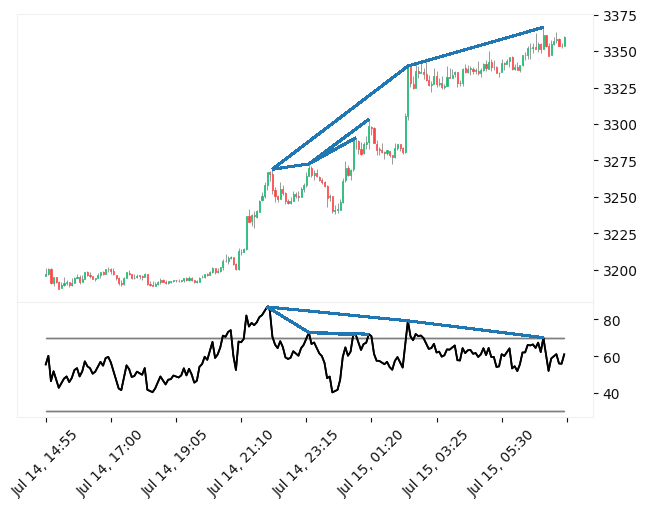

In [109]:
df = df.tail(200)
price_lines, rsi_lines = detect_divergence(df)

plots = [
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=30, y2=30, color="gray")),
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=70, y2=70, color="gray")),
]
style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'grid.alpha':0}, figcolor='#fff', facecolor="#fff")
_, axs = mpf.plot(
    df,
    type='candle',
    style=style,
    volume=False,
    ylabel='',
    ylabel_lower='',
    addplot=plots,
    returnfig=True,
    alines=dict(alines=price_lines))

rsi_lines = mpf._utils._construct_aline_collections(dict(alines=rsi_lines), df.index)
axs[2].add_collection(rsi_lines);